                                                                            Luis Ramirez Camargo, June 2020

# PV output from ERA5-land and MERRA2 data using PV_lib
This notebook calculates hourly PV power output for the location of the Chilean PV installations uing PV_LIB. The output is calculated for installations oriented north and with an inclination equal to the latitude, as well as for single tracker systems. The calculation is made in all cases using ERA5-land or MERRA2 data. This notebook requires the time series generated using the notebook get_time_series_from_era5_land_and_merra2_for_pv_calculation. Furthermore, the output of this notebook is part of the input for the validation and intercomparison procedure in pv_validation_ERA5_land_MERRA2_rn. 


## 1) import the libraries and data

In [1]:
import os
import itertools
import xarray as xr
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.iotools import read_tmy3
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import geopandas
import glob
from tkinter import Tcl
import gc
import unidecode
import scipy as sp
import scipy.stats
import seaborn as sns
from pathlib import Path
from pvlib.tools import cosd, sind

## Import locations

In [2]:
installations_chile_pre = \
Path("/home/lramirez/my-data/pv_generation_per_country/\
chile/solares_fd0779de_0870_4194_b962_83a842d8c316.shp")
def clean_installations_locations(installations_chile_pre):
    '''creates a data frame with the location and basic 
    characteristics of the large PV installations in Chile'''
    pvs_chile = geopandas.read_file(installations_chile_pre)
    pvs_chile_4326 = pvs_chile.to_crs(epsg=4326)
    installations_list = pvs_chile_4326["NOMBRE"]
    installations_chile = pd.DataFrame({'latitude': pvs_chile_4326.geometry.y.values, 
                        'longitude': pvs_chile_4326.geometry.x.values, 
                        'size': pvs_chile_4326['POTENCIA'].values, 
                        'official_operation_start': pd.to_datetime(pvs_chile_4326['F_OPERACIO'].values), 
                        'end_time': pd.to_datetime('2018-12-30')},
                       index=installations_list)
    return installations_chile

installations_chile = clean_installations_locations(installations_chile_pre)

## Import the weather parameters

In [3]:
era5l_radiation_file = Path('time_series_from_reanalysis_data_sets/eral5_radiation_all_installations.csv')
era5l_temperature_file = Path('time_series_from_reanalysis_data_sets/eral5_temperature_all_installations.csv')
era5l_wind_speed_file = Path('time_series_from_reanalysis_data_sets/eral5_wind_speed_all_installations.csv')
merra2_radiation_file = Path('time_series_from_reanalysis_data_sets/merra2_radiation_all_installations.csv')
merra2_temperature_file = Path('time_series_from_reanalysis_data_sets/merra2_temperature_all_installations.csv')
merra2_wind_speed_file = Path('time_series_from_reanalysis_data_sets/merra2_wind_speed_all_installations.csv')
#the time index is imported as UTC 
era5l_radiation = pd.read_csv(era5l_radiation_file,
                              index_col=0,
                              parse_dates=True).tz_localize(tz='UTC')
era5l_temperature = pd.read_csv(era5l_temperature_file,
                                index_col=0,
                                parse_dates=True).tz_localize(tz='UTC')
era5l_wind_speed = pd.read_csv(era5l_wind_speed_file,
                               index_col=0,
                               parse_dates=True).tz_localize(tz='UTC')
merra2_radiation = pd.read_csv(merra2_radiation_file,
                               index_col=0,
                               parse_dates=True).tz_localize(tz='UTC')
merra2_temperature = pd.read_csv(merra2_temperature_file,
                                 index_col=0,
                                 parse_dates=True).tz_localize(tz='UTC')
merra2_wind_speed = pd.read_csv(merra2_wind_speed_file,
                                index_col=0,
                                parse_dates=True).tz_localize(tz='UTC')

In [4]:
def shift_and_clean(resample_time_step, shifting, reanalysis_variable):
    '''resample a a data frame to a certain time step, keeps the stored values only once,
    shift the time a defined amount of time steps and drops all the NaN values in a data frame.
    the output data frame has the same lenght as the input data frame but the time index is 
    shifted. eg. remsampe_time_step ='30min', shifting=1, reanalysis_variable=era5l_radiation'''
    reanalysis_variable_shifted = reanalysis_variable.resample(resample_time_step).asfreq().shift(periods = shifting).dropna()
    return reanalysis_variable_shifted

In [41]:
#run shift_and_clean for all variables of the 2 different reanalysis
merra2_radiation_30m = shift_and_clean('30min', 1, merra2_radiation)
merra2_temperature_30m = shift_and_clean('30min', 1, merra2_temperature)
merra2_wind_speed_30m = shift_and_clean('30min', 1, merra2_wind_speed)
era5l_radiation_30m = shift_and_clean('30min', 1, era5l_radiation)
era5l_temperature_30m = shift_and_clean('30min', 1, era5l_temperature)
era5l_wind_speed_30m = shift_and_clean('30min', 1, era5l_wind_speed)

## Caculate the PV output assuming direction north and inclination equal to the latitude

In [52]:
def pv_output_system(radiation_pre, temperature_pre, wind_speed_pre,lons,lats,tracking,installed_capacity_kWp):
    '''calculates ac output in Wh of a PV installation either heading
    to the ecuator and an inclination equal to the latitude or assuming 
    a single-axis tracking system for a particular location. It requires
    time series of solar radiation, temperature (in °C at 2 m)and wind 
    speed (in m/s at 1 m altitude) as well as the coordinates of the location
    and either 0 or 1 to define the type of tracker as input'''
    location = Location(latitude=lats, longitude=lons, tz='UTC')
    temperature = temperature_pre
    wind_speed = wind_speed_pre
    ghi_input = radiation_pre
    timeindex = ghi_input.asfreq(freq='1H').index
    dayofyear = timeindex.dayofyear
    ephem_pv_installation = pvlib.solarposition.pyephem(timeindex, 
                                                        location.latitude, 
                                                        location.longitude,
                                                        temperature=np.mean(temperature))
    Zenith = ephem_pv_installation['zenith']
    if tracking == 0:
        slope = lats
        if lats >= 0:
            aspect = 0
        elif lats < 0:
            aspect = 180
    elif tracking == 1:
 
        tracker_data = pvlib.tracking.singleaxis(ephem_pv_installation['apparent_zenith'],
                                                 ephem_pv_installation['azimuth'],
                                                 axis_tilt=0,
                                                 axis_azimuth=0,
                                                 max_angle=90,
                                                 backtrack=True,
                                                 gcr=2.0/7.0)
        slope = tracker_data['surface_tilt']
        aspect = tracker_data['surface_azimuth']
    #solartime = ephem_pv_installation['solar_time'] 
    #clearsky_irrad = location.get_clearsky(timeindex)
    #clearsky_irrad['2018-01-01'].plot()
    dni_pre = pvlib.irradiance.disc(ghi_input,Zenith,dayofyear)['dni']
    dhi_pre = ghi_input - dni_pre *cosd(Zenith)
    weather = pd.DataFrame({'ghi': ghi_input, 
                        'dni': dni_pre, 
                        'dhi': dhi_pre, 
                        'temp_air': temperature, 
                        'wind_speed': wind_speed},
                       index=timeindex)
    #weather['2017-06-01':'2017-06-08'].plot(figsize=(18,6))
    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
    cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
    #the follow selection requires some sort of automatization
    sandia_module = sandia_modules['Silevo_Triex_U300_Black__2014_']
    #Tries with the stc where understimating the yearly sum. Decided to use the PTC
    PTC = 280.5
    cec_inverter = cec_inverters['ABB__MICRO_0_3_I_OUTD_US_240_240V__CEC_2014_']
    #check that the Paco is at least equal to the STC
    number_of_panels_1kWp = 1000/PTC
    area_1kWp = number_of_panels_1kWp * sandia_module['Area']
    system = PVSystem(surface_tilt=slope, surface_azimuth=aspect,
                  module_parameters=sandia_module,
                  inverter_parameters=cec_inverter)
    mc = ModelChain(system, location)
    mc.run_model(times=weather.index, weather=weather)
    pv_output = (mc.ac * number_of_panels_1kWp * installed_capacity_kWp).fillna(0)
    return pv_output

In [53]:
def get_pv_output_optimal_all(radiation_df, temperature_df, wind_speed_df, tracking, installed_capacity_kWp):
    '''runs the function pv_output_system for all PV plants in Chile
    and creates a data frame with the times series'''
    date_range = pd.date_range(start='2014-01-01 00:00:00', end='2018-12-31 22:00:00', freq='H')
    pv_output_optimal = pd.DataFrame(columns=installations_chile.index, index=pd.to_datetime(date_range))
    for installation in installations_chile.index:
        pv_output_optimal[installation] = pv_output_system(radiation_df[installation], 
                                                           temperature_df[installation], 
                                                           wind_speed_df[installation],
                                                           installations_chile.longitude[installation],
                                                           installations_chile.latitude[installation], 
                                                           tracking,
                                                           installed_capacity_kWp).values
    return pv_output_optimal

In [54]:
timeseries_pv_optimal_era5l = get_pv_output_optimal_all(era5l_radiation_30m, 
                                                        era5l_temperature_30m,
                                                        era5l_wind_speed_30m, 0, 1)

In [56]:
timeseries_pv_optimal_merra2 = get_pv_output_optimal_all(merra2_radiation_30m, 
                                                        merra2_temperature_30m,
                                                        merra2_wind_speed_30m, 0, 1)

In [57]:
timeseries_pv_tracking_era5l = get_pv_output_optimal_all(era5l_radiation_30m, 
                                                        era5l_temperature_30m,
                                                        era5l_wind_speed_30m, 1, 1)

In [58]:
timeseries_pv_tracking_merra2 = get_pv_output_optimal_all(merra2_radiation_30m, 
                                                        merra2_temperature_30m,
                                                        merra2_wind_speed_30m, 1, 1)

In [65]:
#save the data frames of PV output to csv files
timeseries_pv_optimal_era5l.to_csv(Path('intermediate_results/timeseries_pv_optimal_era5l.csv'))
timeseries_pv_optimal_merra2.to_csv(Path('intermediate_results/timeseries_pv_optimal_merra2.csv'))
timeseries_pv_tracking_era5l.to_csv(Path('intermediate_results/timeseries_pv_tracking_era5l.csv'))
timeseries_pv_tracking_merra2.to_csv(Path('intermediate_results/timeseries_pv_tracking_merra2.csv'))

## transform radiation data into capacity factors 

In [73]:
def capacity_factors(file_with_df_pv_output):
    cf_2 = pd.read_csv(file_with_df_pv_output, index_col=0, parse_dates=True)
    cf_1 =  cf_2/cf_2.max().copy()
    cf = cf_1.where(cf_2 > 0,0).copy()
    return cf

In [74]:
#calculate the capacity factors for the PV output data sets
timeseries_capacity_factors_pv_optimal_era5l = capacity_factors(Path('intermediate_results/timeseries_pv_optimal_era5l.csv'))
timeseries_capacity_factors_pv_optimal_merra2 = capacity_factors(Path('intermediate_results/timeseries_pv_optimal_merra2.csv'))
timeseries_capacity_factors_pv_tracking_era5l = capacity_factors(Path('intermediate_results/timeseries_pv_tracking_era5l.csv'))
timeseries_capacity_factors_pv_tracking_merra2 = capacity_factors(Path('intermediate_results/timeseries_pv_tracking_merra2.csv'))

In [ ]:
#save the data frames of capacity factors to csv files
timeseries_pv_optimal_era5l.to_csv(Path('intermediate_results/timeseries_pv_optimal_era5l.csv'))
timeseries_pv_optimal_merra2.to_csv(Path('intermediate_results/timeseries_pv_optimal_merra2.csv'))
timeseries_pv_tracking_era5l.to_csv(Path('intermediate_results/timeseries_pv_tracking_era5l.csv'))
timeseries_pv_tracking_merra2.to_csv(Path('intermediate_results/timeseries_pv_tracking_merra2.csv'))

In [ ]:
######

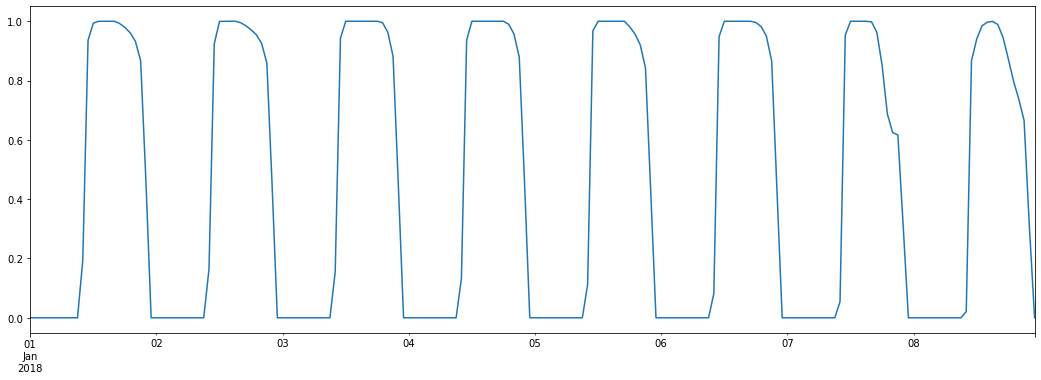

In [82]:
timeseries_capacity_factors_pv_tracking_merra2[installation]['2018-01-01':'2018-01-08'].plot(figsize=(18,6))

In [27]:
pv_output_system_optimal_test = pv_output_system(era5l_radiation[installation], 
                                                         era5l_temperature[installation], 
                                                         era5l_wind_speed[installation],
                                                         installations_chile.longitude[installation],
                                                         installations_chile.latitude[installation], 0, 1)

In [28]:
pv_output_system_optimal_test_15m = pv_output_system(era5l_radiation_30m[installation], 
                                                         era5l_temperature_30m[installation], 
                                                         era5l_wind_speed_30m[installation],
                                                         installations_chile.longitude[installation],
                                                         installations_chile.latitude[installation], 0, 1)

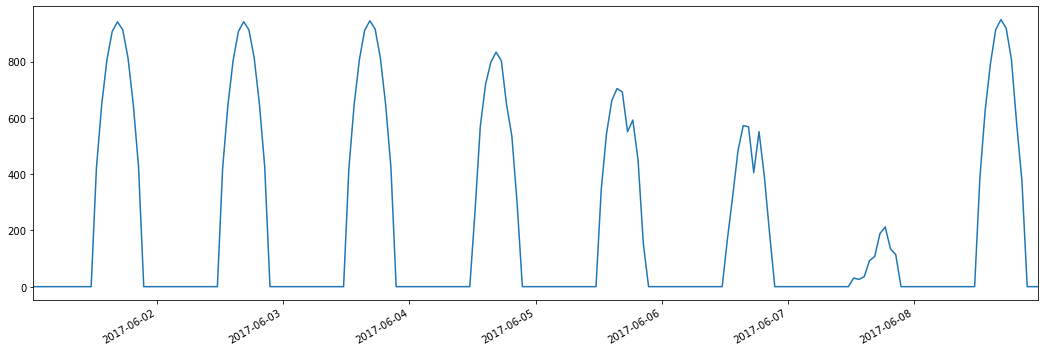

In [29]:
pv_output_system_optimal_test_15m['2017-06-01':'2017-06-08'].plot(figsize=(18,6))

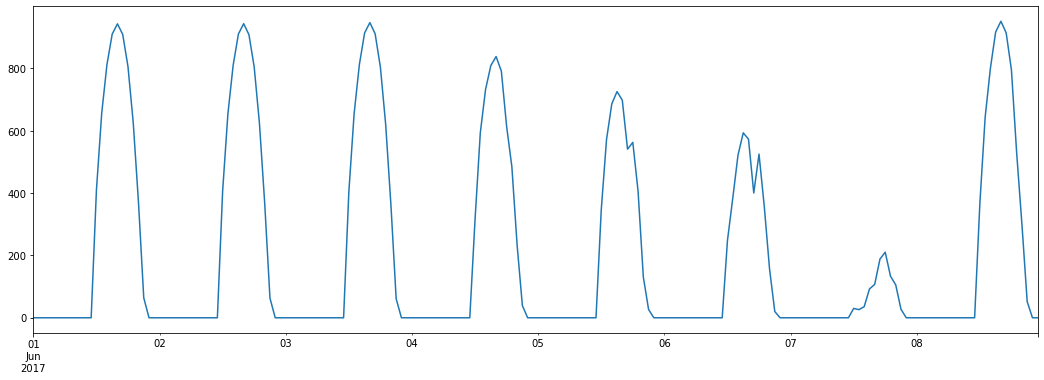

In [30]:
pv_output_system_optimal_test['2017-06-01':'2017-06-08'].plot(figsize=(18,6))

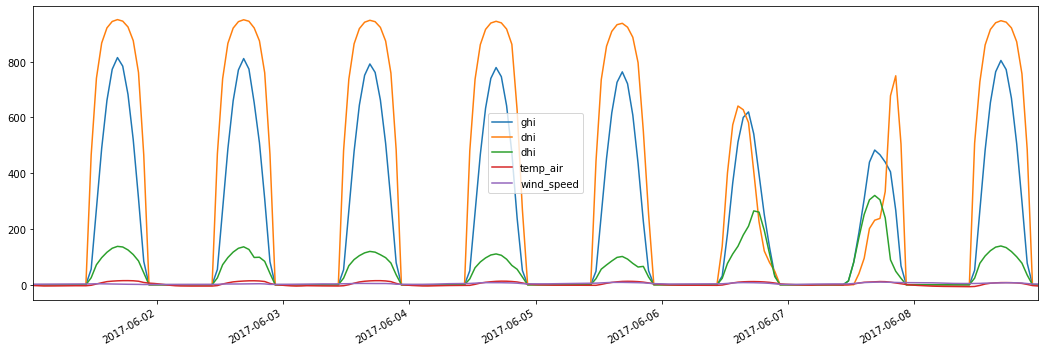

In [253]:
pv_output_system_optimal_test_30m_merra2 = pv_output_system_optimal(merra2_radiation_30min[installation], 
                                                         merra2_temperature_30min[installation], 
                                                         merra2_wind_speed_30min[installation],
                                                         installations_chile.longitude[installation],
                                                         installations_chile.latitude[installation], 1, 1)

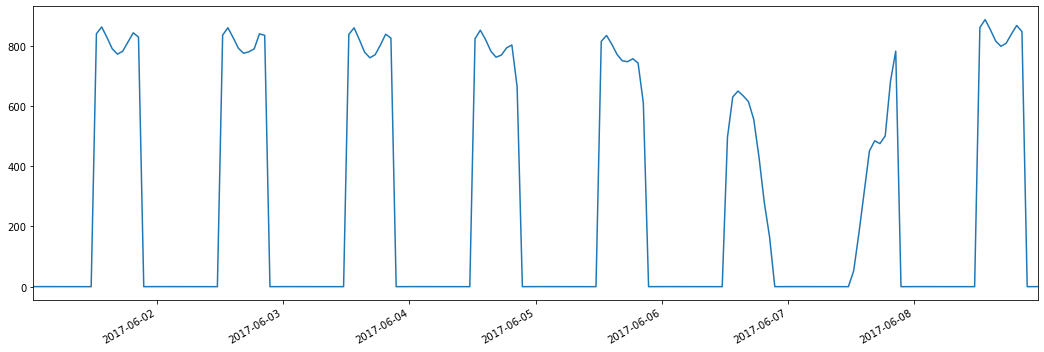

In [254]:
pv_output_system_optimal_test_30m_merra2['2017-06-01':'2017-06-08'].plot(figsize=(18,6))

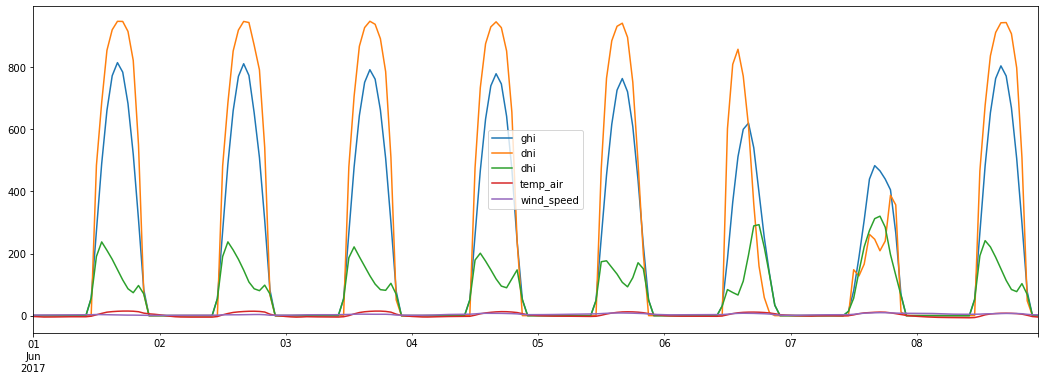

In [255]:
pv_output_system_optimal_test_merra = pv_output_system_optimal(merra2_radiation[installation], merra2_temperature[installation], 
                                                         merra2_wind_speed[installation],
                                                         installations_chile.longitude[installation],
                                                         installations_chile.latitude[installation],1 ,1)

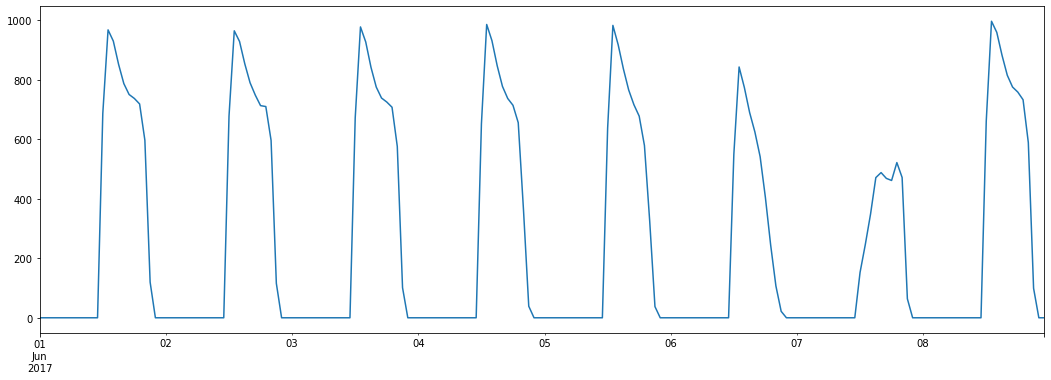

In [256]:
pv_output_system_optimal_test_merra['2017-06-01':'2017-06-08'].plot(figsize=(18,6))

## Addition: clear sky radiation values 

In [163]:
time_horizon = pd.date_range(start='2014-01-01 00:00:00', end='2018-12-31 23:00:00', freq='H')

def get_irrad_single_axis_clear_sky(lats, lons, time_horizon):
    pv_installation = Location(lats, lons, tz='UTC')
    ephem_pv_installation = pvlib.solarposition.get_solarposition(time_horizon.tz_localize(pv_installation.tz), pv_installation.latitude, pv_installation.longitude)
    tracker_data = pvlib.tracking.singleaxis(ephem_pv_installation['apparent_zenith'],
                                             ephem_pv_installation['azimuth'],
                                             axis_tilt=0,
                                             axis_azimuth=0,
                                             max_angle=90,
                                             backtrack=True,
                                             gcr=2.0/7.0)
    irrad_data = pv_installation.get_clearsky(time_horizon.tz_localize(pv_installation.tz))
    dni_et = pvlib.irradiance.get_extra_radiation(irrad_data.index, method='asce')
    haydavies_diffuse = pvlib.irradiance.haydavies(tracker_data['surface_tilt'], tracker_data['surface_azimuth'], 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_pv_installation['apparent_zenith'], ephem_pv_installation['azimuth'])
    ground_irrad = pvlib.irradiance.get_ground_diffuse(tracker_data['surface_tilt'], irrad_data['ghi'], albedo=.25)
    global_in_plane = (cosd(tracker_data['aoi'])*irrad_data['dni']) + haydavies_diffuse + ground_irrad
    return irrad_data, dni_et, global_in_plane

In [21]:
installation = 'PUERTO SECO SOLAR'#era5l_radiation.columns[0]

In [161]:
test = get_irrad_single_axis_clear_sky(installations_chile.latitude[installation],
                                       installations_chile.longitude[installation],
                                       time_horizon)

/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


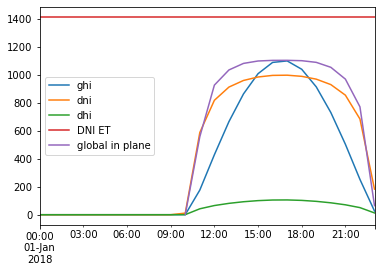

In [183]:
test[0]['2018-01-01'].plot()
test[1]['2018-01-01'].plot(label='DNI ET')
test[2]['2018-01-01'].plot(label='global in plane')
plt.legend()